# GDrive Settings

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# change working directory
%cd /content/gdrive/My Drive/DS\ para\ Negocios/

/content/gdrive/My Drive/DS para Negocios


# Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

import pickle

# no warning message
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Analysis

In [26]:
# load dataset
df_credit_risk = pd.read_csv("acquisition_train.csv")

print(f'Shape of dataset {df_credit_risk.shape}')
df_credit_risk.head(3)

Shape of dataset (45000, 43)


,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN


## Info

In [27]:
# info dataset
df_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

Alguns atributos possuem valores muitos discrepantes:     
1.   reported_income: valores infinitos
2.   external_data_provider_email_seen_before: valores negativos



In [28]:
# statistic dataset - quantitative
df_credit_risk.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score_3,44438.0,3.479833e+02,110.429165,0.000000,270.000000,340.000000,420.000000,9.900000e+02
score_4,45000.0,1.000068e+02,3.178080,86.191572,97.867036,100.018900,102.141797,1.139782e+02
score_5,45000.0,5.000371e-01,0.288326,0.000035,0.252150,0.500753,0.748816,9.999734e-01
score_6,45000.0,9.992523e+01,10.016549,60.663039,93.198353,99.974796,106.640275,1.421924e+02
risk_rate,44438.0,2.967172e-01,0.101933,0.000000,0.220000,0.290000,0.360000,9.000000e-01
last_amount_borrowed,15044.0,1.378234e+04,8077.571933,1005.180000,7519.502500,12023.465000,19220.270000,3.505960e+04
last_borrowed_in_months,15044.0,4.176389e+01,10.252705,36.000000,36.000000,36.000000,36.000000,6.000000e+01
credit_limit,31200.0,3.438195e+04,36586.982218,0.000000,10000.000000,25647.000000,47086.750000,4.482690e+05
income,44438.0,7.160739e+04,51858.967748,4821.180000,45010.777500,61266.760000,86019.232500,5.000028e+06
ok_since,18455.0,3.506974e+01,21.663194,0.000000,17.000000,32.000000,50.000000,1.410000e+02


In [29]:
# statistic dataset - quanlitative
df_credit_risk.describe(exclude=[np.number]).transpose()

,count,unique,top,freq
ids,45000,45000,34ee7c56-4611-676f-88ef-6579cce00691,1
target_default,41741,2,False,35080
score_1,44438,7,DGCQep2AE5QRkNCshIAlFQ==,14523
score_2,44438,35,osCzpM4hJrxugqWWuZmMWw==,3573
reason,44434,14874,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,4463
facebook_profile,40542,2,False,24933
state,44438,50,xsd3ZdsI3356I3xMxZeiqQ==,7429
zip,44438,823,3k2JCQ8Bp5oDwaI39ZJgHA==,566
channel,44438,1,NCqL3QBx0pscDnx3ixKwXg==,44438
job_name,41664,32265,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,167


Existem atributos que possuem mais da metade de valores ausentes e que serão excluídos no processo e limpeza de dados:
* *target_fraud*;
* *last_amount_borrowed*;
* *last_borrowed_in_months*;
* *external_data_provider_credit_checks_last_2_year*;
* *ok_since0*.

In [30]:
# null values
(df_credit_risk.isnull().sum() / df_credit_risk.shape[0] * 100).sort_values(ascending=False)

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

Existem atributos com um único valor para todos os registros  do dataset o que gera pouco valor à análise:
* *external_data_provider_credit_checks_last_2_year*;
* *channel*.

e também com o número de valores únicos igual ao tamanhao do dataset:
* *ids*;
* *profile_phone_number*;
* *shipping_zip_code*.

In [31]:
# unique values
df_credit_risk.nunique().sort_values()

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

## Data cleaning

Colunas excluídas:    
*  *last_amount_borrowed*, *last_borrowed_in_months*, *ok_since* e *external_data_provider_credit_checks_last_2_year* possuem mais de 50% do dataset de valores ausentes, o que torna difícil substituir esses valores, podendo gerar erros durante a predição;

* *target_fraud* é uma variável alvo destinada para avaliar a possibilidade de fraude no cartão de crédito;

* *job_name*, *external_data_provider_first_name*, *profile_phone_number* e *zip* são do tipo string e possuem muitos valores categóricos distintos, difíceis de serem agrupados;

* *ids* serve para identificar um determinado cliente, portanto, não agrega valor;

* *channel*, *profile_phone_numbere*  *shipping_zip_code* possuem um valor único, não agrega valor.



In [54]:
df_credit_risk_clean = df_credit_risk.copy()

del_cols = ['external_data_provider_credit_checks_last_2_year', 'ok_since', 'channel',
        'target_fraud','ids', 'last_amount_borrowed', 'profile_phone_number', 
        'reason', 'zip', 'user_agent', 'job_name', 'external_data_provider_first_name',
        'last_borrowed_in_months', 'state', 'shipping_zip_code', 'lat_lon']

# drop columns
df_credit_risk_clean = df_credit_risk_clean.drop(labels=del_cols, axis=1)

# inf's values
df_credit_risk_clean = df_credit_risk_clean[df_credit_risk_clean['reported_income'] != np.inf]

# negatives values
df_credit_risk_clean.loc[df_credit_risk_clean['external_data_provider_email_seen_before'] < 0,
             'external_data_provider_email_seen_before'] = np.nan

# change facebook_profile column
df_credit_risk_clean['facebook_profile'].fillna(value=False, inplace=True, axis=0)
df_credit_risk_clean['facebook_profile'] = df_credit_risk_clean['facebook_profile'].map({True: 'Sim', False: 'Não'})

# chnage email colums
df_credit_risk_clean.loc[df_credit_risk_clean['email'] == 'hotmaill.com', 'email'] = 'hotmail.com'
df_credit_risk_clean.loc[df_credit_risk_clean['email'] == 'gmaill.com', 'email'] = 'gmail.com'

# change the value of the shipping_state column
df_credit_risk_clean['shipping_state'] = df_credit_risk_clean['shipping_state'].str[-2:]

# clear target
df_credit_risk_clean.dropna(subset=['target_default'], inplace=True)
df_credit_risk_clean['target_default'] = df_credit_risk_clean['target_default'].map({True: 1, False: 0})

In [55]:
# null values
(df_credit_risk_clean.isnull().sum() / df_credit_risk_clean.shape[0] * 100).sort_values(ascending=False)

external_data_provider_credit_checks_last_year     33.607678
credit_limit                                       31.407319
n_issues                                           26.164367
marketing_channel                                   7.920816
external_data_provider_email_seen_before            7.846431
n_bankruptcies                                      0.323935
n_defaulted_loans                                   0.028794
facebook_profile                                    0.000000
score_1                                             0.000000
score_2                                             0.000000
score_3                                             0.000000
score_4                                             0.000000
score_5                                             0.000000
score_6                                             0.000000
risk_rate                                           0.000000
income                                              0.000000
profile_tags            

## Missing values

In [56]:
def fill_proportional(column):
    """
    Fill in missing values in the same proportion as present values

     Takes a column and returns the column with missing values filled 
     in proportion to previously existing values.
    """
    
    # generating the dictionary with unique values and their percentages
    percentages = column.value_counts(normalize=True).to_dict()

    # transforming dictionary keys and values into lists      
    percent = [percentages[key] for key in percentages]
    labels = [key for key in percentages]

    # using lists to fill null values in correct proportion 
    s = pd.Series(np.random.choice(labels, p=percent, size=column.isnull().sum()))
    column = column.fillna(s)
    
    # checking that all missing values have been filled in 
    #   and filling in those that have not been
    if len(column.isnull()) > 0:
        column.fillna(value=max(percentages, key=percentages.get), inplace=True, axis=0)
        
    return column

In [57]:
# input values
#  -fill categorical variables using function;
#  -fill numeric variables with the median.
for column in df_credit_risk_clean.iloc[:,1:].columns.tolist():
    if df_credit_risk_clean[column].dtypes == 'O':
        df_credit_risk_clean[column] = fill_proportional(df_credit_risk_clean[column])
    else:
        df_credit_risk_clean[column].fillna(value=df_credit_risk_clean[column].median(), inplace=True, axis=0)

In [58]:
# null values
(df_credit_risk_clean.isnull().sum() / df_credit_risk_clean.shape[0] * 100).sort_values(ascending=False)

profile_tags                                       0.0
n_bankruptcies                                     0.0
score_1                                            0.0
score_2                                            0.0
score_3                                            0.0
score_4                                            0.0
score_5                                            0.0
score_6                                            0.0
risk_rate                                          0.0
credit_limit                                       0.0
income                                             0.0
facebook_profile                                   0.0
real_state                                         0.0
n_defaulted_loans                                  0.0
shipping_state                                     0.0
n_accounts                                         0.0
n_issues                                           0.0
application_time_applied                           0.0
applicatio

## Feature Engineering

### application_time_applied

> aplicações realizadas no período de 0 a 6 h possuem maior probabilidade de terem inadimplência



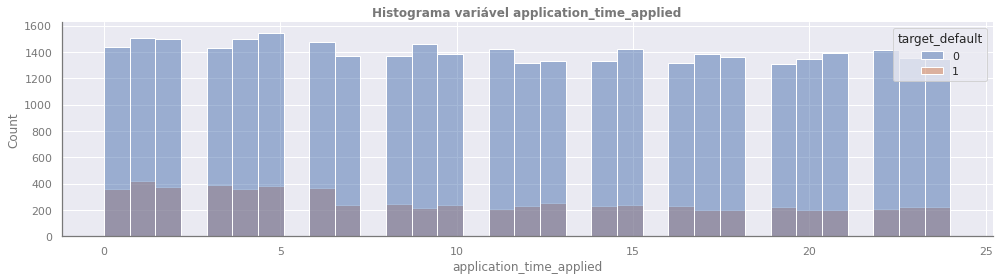

In [59]:
# change to int type
df_credit_risk_clean['application_time_applied'] = (df_credit_risk_clean['application_time_applied'].str[:2]).astype('int64')

# parameters
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

# apply 'rc_params'
with plt.rc_context(rc_params):
  fig, ax = plt.subplots( figsize = (14,4) )
  sns.histplot(data = df_credit_risk_clean, x = 'application_time_applied', ax = ax, hue = "target_default")
  ax.set_title("Histograma variável application_time_applied")

  plt.tight_layout()

### profile_tags

In [60]:
# get only tag
df_credit_risk_clean['profile_tags'] = df_credit_risk_clean['profile_tags'].str.extract('\[(.*)\]')
df_credit_risk_clean['profile_tags'] = df_credit_risk_clean['profile_tags'].str.replace("'","").str.replace(",","").str.replace("+","")

df_credit_risk_clean.head(3)

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,profile_tags
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,MT,n19 n8
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,RS,n6 n7 nim
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,Waiting-list,163679.0,RR,n0 n17 nim da


In [61]:
# create algorithm
bag_of_words = CountVectorizer(binary=True, analyzer='word')
words = bag_of_words.fit_transform(df_credit_risk_clean['profile_tags']).todense()

# new dataframe of tags
df_tag = pd.DataFrame(words, columns = bag_of_words.get_feature_names(), index = df_credit_risk_clean.index)

df_tag.head()

,a15,aty,b19,c1,c55,da,dfa,n0,n1,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,n2,n3,n4,n5,n6,n7,n8,n9,nim,proaty
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [62]:
# merge dataframes
df_credit_risk_clean = pd.concat([df_credit_risk_clean, df_tag], axis = 1)

# exclude 'profile_tag'
df_credit_risk_clean.drop(labels = ['profile_tags'], axis = 1, inplace = True)

### marketing_channel, email, facebook_profile

* *@outlook.com* possui maior probabilidade de inadimplência;
* perfil no facebook possue maior probabilidade de inadimplência;





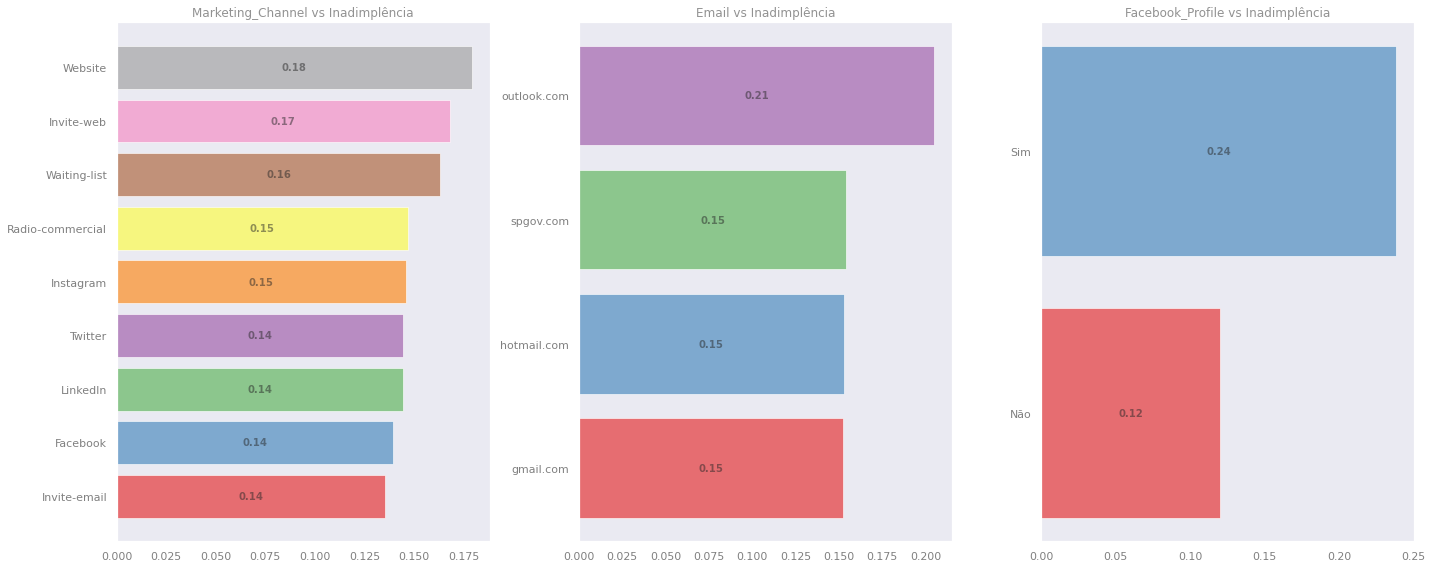

In [63]:
categorical = ['marketing_channel', 'email', 'facebook_profile']

fig = plt.figure(figsize=(20,8))
    
for i in range(len(categorical)):
    to_plot = df_credit_risk_clean.groupby(categorical[i]).target_default.mean().sort_values()
    ax = fig.add_subplot(1, 3, i+1)
    rects = ax.barh(to_plot.index, to_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.grid(False)
    ax.tick_params(labelleft=True)
    ax.set_title(f'{categorical[i].title()} vs Inadimplência', alpha=0.5)
    ax.tick_params(colors='grey')
    
    for rect in (rects):
        width = rect.get_width()
        ax.text(y=rect.get_y() + rect.get_height() / 2, x=width * 0.5, s=round(width, 2), ha='center', va='center', alpha=0.5, fontweight='bold')

plt.tight_layout()
plt.show()

### categorica values
* valores mais altos na coluna *n_bankruptcies* (n_falências) implicam em maior chance de inadimplência;
* valores mais altos na coluna *external_data_provider_email_seen_before* implicam em menor chance de inadimplência;

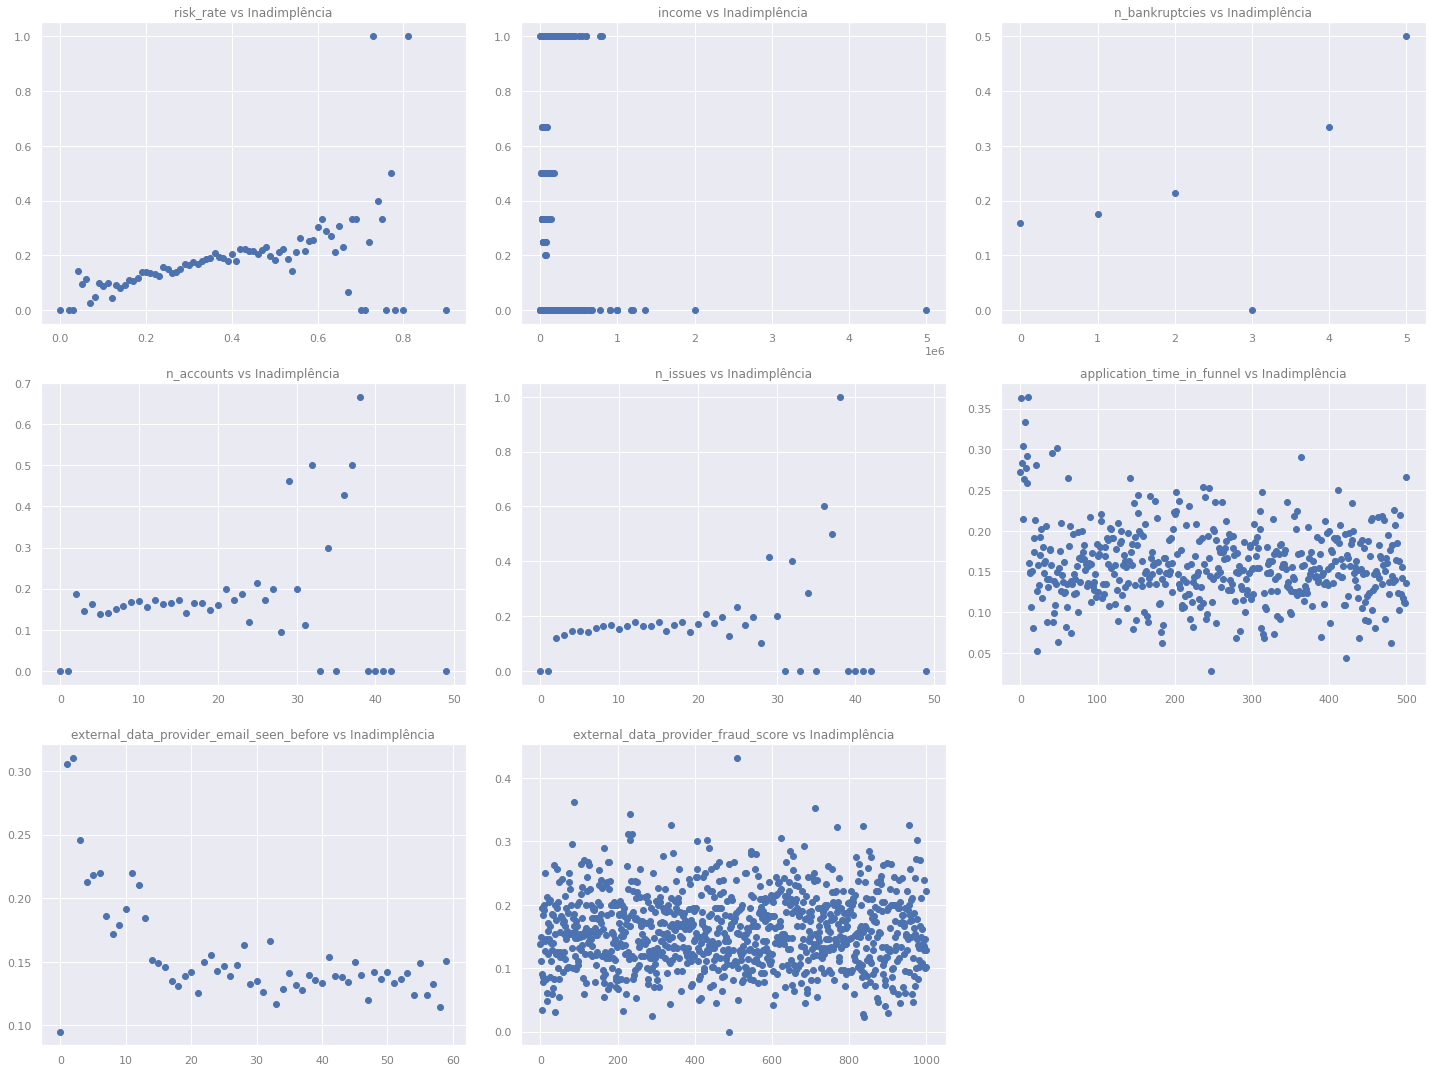

In [64]:
numeric = ['risk_rate', 'income', 'n_bankruptcies', 'n_accounts',
 'n_issues', 'application_time_in_funnel', 'external_data_provider_email_seen_before',
 'external_data_provider_fraud_score']

fig = plt.figure(figsize=(20, 15))

for i in range(len(numeric)):
    num_plot = df_credit_risk_clean.groupby(numeric[i]).target_default.mean()
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(num_plot.index, num_plot)
    ax.set_title(f'{numeric[i]} vs Inadimplência', alpha=0.6)
    ax.tick_params(colors='grey')

plt.tight_layout()
plt.savefig('num.png')
plt.show()

### shipping_state

In [65]:
#Dicionário de estado por região
dict_regiao = {'RS' : 'Sul', 
               'RR': 'Norte', 
               'MT': 'Centro-Oeste', 
               'SP': 'Sudeste', 
               'AC': 'Norte', 
               'MS': 'Centro-Oeste', 
               'PE': 'Nordeste',
               'AM': 'Norte', 
               'CE': 'Nordeste', 
               'AP': 'Norte', 
               'MA': 'Nosdeste', 
               'BA': 'Nordeste', 
               'TO': 'Norte', 
               'RO': 'Norte',
               'GO': 'Centro-Oeste', 
               'SE': 'Nordeste', 
               'RN': 'Nordeste', 
               'MG': 'Sudeste', 
               'ES': 'Sudeste', 
               'PR': 'Sul', 
               'DF': 'Centro-Oeste',
               'SC': 'Sul', 
               'PA': 'Norte', 
               'AL': 'Nordeste', 
               'PB': 'Nordeste'}

In [66]:
#Criando uma variável por região
df_credit_risk_clean['regiao'] = df_credit_risk_clean['shipping_state'].apply(lambda x: dict_regiao[x])


#Eliminando a variável shipping_state
df_credit_risk_clean.drop(labels = ['shipping_state'], axis = 1, inplace = True)

### balanced data

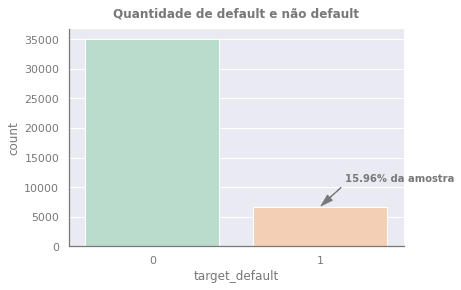

In [67]:
# Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando a Figure e Axes
  fig, ax = plt.subplots()

  #Criando o gráfico de countplot
  sns.countplot(x = 'target_default', 
                data = df_credit_risk_clean,
                ax = ax,
                palette = "Pastel2")
  
  #Exibindo o título
  ax.set_title("Quantidade de default e não default")

  #Armazena o % da amostra
  percentual_default = round((df_credit_risk_clean['target_default'].value_counts()[1] / df_credit_risk_clean.shape[0])*100,2)

  #Criar uma informação no gráfico
  ax.annotate(str(percentual_default) + "% da amostra", 
              xy = (1, df_credit_risk_clean['target_default'].value_counts()[1]), 
              xytext = (25,25), 
              color = "#787878",
              weight = 'bold', 
              textcoords='offset points',
              arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

  #Exibindo o gráfico
  plt.show()

# Model

## Data Preparation

In [69]:
# transform categorical variables into numerical
coluns_encode = ['score_1',
               'score_2',
               'facebook_profile',
               'real_state']

for col in coluns_encode:
    encoder = LabelEncoder().fit(df_credit_risk_clean[col])
    df_credit_risk_clean[col] = encoder.transform(df_credit_risk_clean[col])

col_dummies = coluns_encode + ['application_time_applied', 'email', 'marketing_channel', 'regiao']
col_dummies.remove('facebook_profile')

df_credit_risk_clean = pd.get_dummies(df_credit_risk_clean, columns=col_dummies)

df_credit_risk_clean.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,a15,aty,b19,c1,c55,da,dfa,n0,n1,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,n2,n3,...,application_time_applied_4,application_time_applied_5,application_time_applied_6,application_time_applied_7,application_time_applied_8,application_time_applied_9,application_time_applied_10,application_time_applied_11,application_time_applied_12,application_time_applied_13,application_time_applied_14,application_time_applied_15,application_time_applied_16,application_time_applied_17,application_time_applied_18,application_time_applied_19,application_time_applied_20,application_time_applied_21,application_time_applied_22,application_time_applied_23,application_time_applied_24,email_gmail.com,email_hotmail.com,email_outlook.com,email_spgov.com,marketing_channel_Facebook,marketing_channel_Instagram,marketing_channel_Invite-email,marketing_channel_Invite-web,marketing_channel_LinkedIn,marketing_channel_Radio-commercial,marketing_channel_Twitter,marketing_channel_Waiting-list,marketing_channel_Website,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Nosdeste,regiao_Sudeste,regiao_Sul
0,0,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,1,0.0,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,0,0.0,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,1,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,0,0.0,0.0,10.0,10.0,6,2,1.0,9.0,65,163679.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,0,1.0,0.0,19.0,19.0,406,3,1.0,38.0,815,1086.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,25206.0,60011.29,1,0.0,0.0,11.0,10.0,240,2,1.0,46.0,320,198618.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [70]:
# defining the X and y values
X = df_credit_risk_clean.drop(['target_default'], axis = 1)
y = df_credit_risk_clean['target_default']

# split datset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True, 
                                                    stratify = y,
                                                    random_state = 42)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### balanced data

> balancear os dados utilizando a técninca *under-sampling*, devido a possibilidade de manter integralmente os dados originais associados a *target_default*


In [71]:
#Instanciando o objeto RandomUnderSampler()
rus = RandomUnderSampler(random_state = 0)

#Balanceando a amostra
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#Transformando o array X em dataframe e y em série
X_train_rus = pd.DataFrame(X_train_rus, columns = df_credit_risk_clean.drop(['target_default'], axis = 1).columns.to_list())
y_train_rus = pd.Series(y_train_rus)

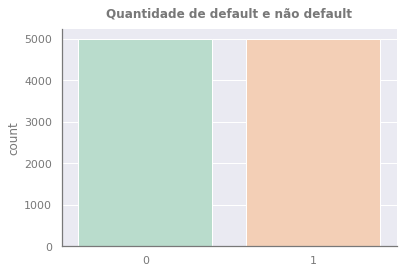

In [72]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando a Figure e Axes
  fig, ax = plt.subplots()

  #Criando o gráfico de countplot
  sns.countplot(x = y_train_rus,
                ax = ax,
                palette = "Pastel2")
  
  #Exibindo o título
  ax.set_title("Quantidade de default e não default")

  #Exibindo o gráfico
  plt.show()

## Machine Learning

### Best model

In [73]:
var_num = ['score_3', 
           'score_4', 
           'score_5', 
           'score_6', 
           'risk_rate', 
           'income', 
           'n_bankruptcies', 
           'n_defaulted_loans', 
           'n_accounts',
           'n_issues', 
           'application_time_applied', 
           'application_time_in_funnel', 
           'external_data_provider_credit_checks_last_month',
           'external_data_provider_credit_checks_last_year',
           'external_data_provider_email_seen_before',
           'external_data_provider_fraud_score', 
           'reported_income']

In [74]:
# K_fold parameters for cross_validation
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# standardizing the numeric variables
num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), df_credit_risk_clean.drop(['target_default'], axis = 1).columns.to_list())],
                         remainder='passthrough')

In [75]:
name_model = []
accuracy = []

# models with hyperparameters
model_rl = LogisticRegression(random_state = 42)

model_rf = RandomForestClassifier(random_state = 42)

model_svc = SVC(random_state = 42)

model_knn = KNeighborsClassifier()

model_xgb = XGBClassifier(random_state = 42)

model_lgbm = LGBMClassifier(random_state = 42)

# apply cross_validation to each model and store the result
for model in [model_rl, model_rf, model_svc, model_knn, model_xgb, model_lgbm]:
  pipe = make_pipeline(num_scaled, model)
  
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  name_model.append(model.__class__.__name__)
  accuracy.append(score.mean())

# list into dataframe
df_model = pd.DataFrame(data = accuracy, 
                        index = name_model, 
                        columns = ['ROC_AUC'])

df_model

,ROC_AUC
LogisticRegression,0.720792
RandomForestClassifier,0.710038
SVC,0.709701
KNeighborsClassifier,0.620384
XGBClassifier,0.720557
LGBMClassifier,0.707901


### Logistic Regression

In [76]:
pipe_lr = make_pipeline(num_scaled, LogisticRegression(random_state = 42))

# parameters for GridSearch
param_grid_lr = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
              "logisticregression__C": [100, 10, 1, 0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

clf_lr = GridSearchCV(estimator = pipe_lr,
                   param_grid = param_grid_lr,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   cv = k_fold)

clf_lr.fit(X = X_train_rus, 
           y = y_train_rus)

# best parameter
clf_lr.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

In [78]:
# score fo the best parameters
clf_lr.best_score_

0.7218066980992842

### XGBoost

In [ ]:
pipe_xgb = make_pipeline(num_scaled, XGBClassifier(random_state = 42))

# parameters for GridSearch
param_grid_xgb = {"xgbclassifier__min_child_weight": [1, 5, 10],
                  "xgbclassifier__gamma": [0.5, 1, 1.5, 2, 5],
                  "xgbclassifier__subsample": [0.6, 0.8, 1.0],
                  "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
                  "xgbclassifier__max_depth": [3, 4, 5]
                 }

clf_xgb = GridSearchCV(estimator = pipe_xgb,
                   param_grid = param_grid_xgb,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   cv = k_fold)

clf_xgb.fit(X = X_train_rus, 
            y = y_train_rus)

clf_xgb.best_params_

In [ ]:
# best parameter
clf_xgb.best_score_

0.7229131289848809

## Feature Selection

### Logistic Regression

In [81]:
model_lr = LogisticRegression(C= 0.1,
                              penalty='l1',
                              solver='saga',
                              random_state = 42)

# k features
k_val = []
score_val = []

for k in range(2, X_train_rus.shape[1], 2):
  selector = SelectFromModel(model_lr, 
                             max_features = k, 
                             threshold = -np.inf)

  selector.fit(X_train_rus, y_train_rus)
  mask = X_train_rus.columns[selector.get_support()].to_list()

  X_train_rus_selector = X_train_rus[mask]
  
  # creating a set for each list for comparison purposes
  s1 = set(mask)
  s2 = set(var_num)

  if (s1.intersection(s2) == set()):
    pipe = make_pipeline(model_lr)
  
  else:
    num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), list(s1.intersection(s2)))],
                         remainder='passthrough')

    pipe = make_pipeline(num_scaled, model_lr)

  score = cross_val_score(estimator = pipe,
                          X = X_train_rus_selector,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Armazenando k
  k_val.append(k)
  score_val.append(score.mean())

df_feature_selection_lr = pd.DataFrame(data = score_val, index = k_val, columns = ['Score'])

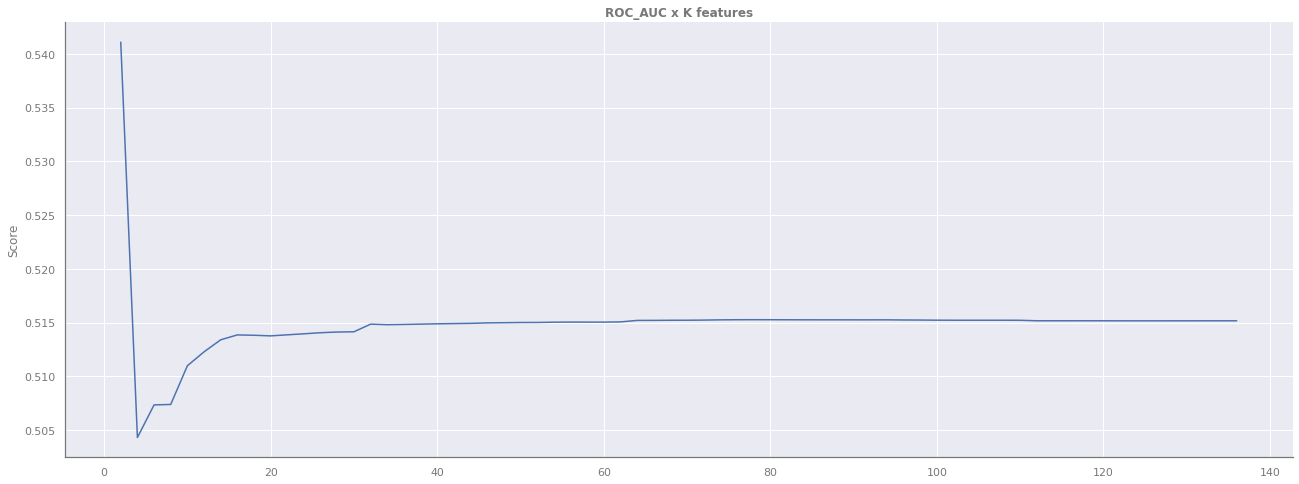

In [82]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #instanciando o axes e figure do matplotlib
  fig, ax = plt.subplots(figsize = (22,8))

  #Construindo o gráfico 
  sns.lineplot(
                x = df_feature_selection_lr.index.to_list(),
                y = df_feature_selection_lr['Score'],
                ci = None,
                ax = ax,
              )
  
  #Colocando o título no gráfico
  ax.set_title("ROC_AUC x K features")

  #Exibindo o gráfico

  plt.show()

In [121]:
# n_features with best score
n_feature = (df_feature_selection_lr.index[df_feature_selection_lr['Score'] == df_feature_selection_lr['Score'].max()])[0]
#find columns
selector_lr = SelectFromModel(model_lr, 
                           max_features = n_feature, 
                           threshold = -np.inf)
  
selector_lr.fit(X_train_rus, y_train_rus)

columns_features_lr = X_train_rus.columns[selector_lr.get_support()].to_list()

### XGBoost

In [126]:
model_xgb = XGBClassifier(colsample_bytree= 0.8,
                         gamma= 5,
                         max_depth= 3,
                         min_child_weight= 10,
                         subsample= 1.0)

# k features
k_val = []
score_val = []

for k in range(2, X_train_rus.shape[1], 2):
  selector = SelectFromModel(model_xgb, 
                             max_features = k, 
                             threshold = -np.inf)

  selector.fit(X_train_rus, y_train_rus)
  mask = X_train_rus.columns[selector.get_support()].to_list()

  X_train_rus_selector = X_train_rus[mask]
  
  # creating a set for each list for comparison purposes
  s1 = set(mask)
  s2 = set(var_num)

  if (s1.intersection(s2) == set()):
    pipe = make_pipeline(model_xgb)
  
  else:
    num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), list(s1.intersection(s2)))],
                         remainder='passthrough')

    pipe = make_pipeline(num_scaled, model_xgb)

  score = cross_val_score(estimator = pipe,
                          X = X_train_rus_selector,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Armazenando k
  k_val.append(k)
  score_val.append(score.mean())

df_feature_selection_xgb = pd.DataFrame(data = score_val, index = k_val, columns = ['Score'])

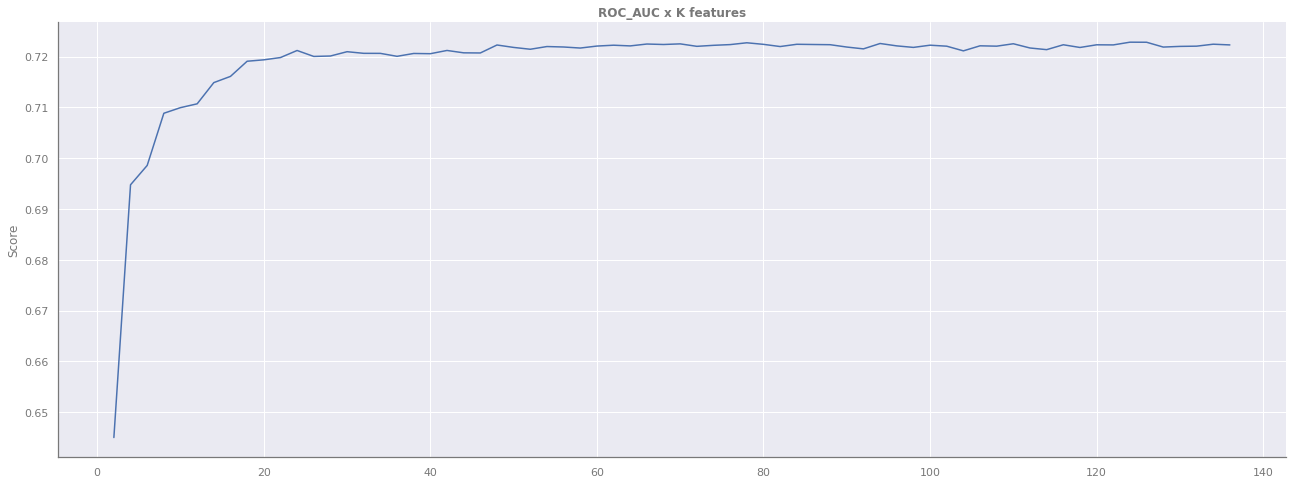

In [127]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #instanciando o axes e figure do matplotlib
  fig, ax = plt.subplots(figsize = (22,8))

  #Construindo o gráfico 
  sns.lineplot(
                x = df_feature_selection_xgb.index.to_list(),
                y = df_feature_selection_xgb['Score'],
                ci = None,
                ax = ax,
              )
  
  #Colocando o título no gráfico
  ax.set_title("ROC_AUC x K features")

  #Exibindo o gráfico

  plt.show()

In [128]:
# n_features with best score
n_feature = (df_feature_selection_xgb.index[df_feature_selection_xgb['Score'] == df_feature_selection_xgb['Score'].max()])[0]
# n_feature = 60
#find columns
selector_xgb = SelectFromModel(model_xgb, 
                           max_features = n_feature, 
                           threshold = -np.inf)
  
selector_xgb.fit(X_train_rus, y_train_rus)

columns_features_xgb = X_train_rus.columns[selector_xgb.get_support()].to_list()

## Cutoff optimization

### Logistic Regression

In [123]:
# selecting the chosen features
X_train_rus_selector_lr = X_train_rus[columns_features_lr]

score_medio = []
lista_cutoff = []

for cont in range(1, 98, 1):
  # varying the cutoff
  cutoff = 0.01 + cont * 0.01

  # K_fold split score
  score_cutoff = []

  # k_fold index
  for train_index, test_index in k_fold.split(X_train_rus_selector_lr):

    # k_fold index train and test split
    X_train, X_test = X_train_rus_selector_lr.loc[train_index], X_train_rus_selector_lr.loc[test_index]
    y_train, y_test = y_train_rus.loc[train_index], y_train_rus.loc[test_index]

    scaler = StandardScaler()
    
    # standardizing numeric variables
    for feature in columns_features_lr:
      X_train[feature] = scaler.fit_transform(X_train[feature].values.reshape(-1,1))
      X_test[feature] = scaler.transform(X_test[feature].values.reshape(-1,1))
    
    model_lr.fit(X = X_train, y = y_train)

    y_proba = model_lr.predict_proba(X_test)
    y_proba_df = pd.DataFrame(y_proba)

    # defining the y value according to the cutoff
    y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > cutoff else 0)

    # calculating the F1_Score metric with the cutoff
    score_cutoff.append(f1_score(y_test, y_proba_df['Predict']))

  lista_cutoff.append(cutoff)
  score_medio.append(np.mean(score_cutoff))

In [124]:
cutoff_df = pd.DataFrame(score_medio, index = lista_cutoff, columns = ['Cutoff'])

# f_score max
cutoff_df.loc[cutoff_df['Cutoff'] == cutoff_df['Cutoff'].max()]

,Cutoff
0.4,0.69666


### XGBoost

In [130]:
# selecting the chosen features
X_train_rus_selector_xgb = X_train_rus[columns_features_xgb]

score_medio = []
lista_cutoff = []

for cont in range(1, 98, 1):
  # varying the cutoff
  cutoff = 0.01 + cont * 0.01

  # K_fold split score
  score_cutoff = []

  # k_fold index
  for train_index, test_index in k_fold.split(X_train_rus_selector_xgb):

    # k_fold index train and test split
    X_train, X_test = X_train_rus_selector_xgb.loc[train_index], X_train_rus_selector_xgb.loc[test_index]
    y_train, y_test = y_train_rus.loc[train_index], y_train_rus.loc[test_index]

    scaler = StandardScaler()
    
    # standardizing numeric variables
    for feature in columns_features_xgb:
      X_train[feature] = scaler.fit_transform(X_train[feature].values.reshape(-1,1))
      X_test[feature] = scaler.transform(X_test[feature].values.reshape(-1,1))
    
    model_xgb.fit(X = X_train, y = y_train)

    y_proba = model_xgb.predict_proba(X_test)
    y_proba_df = pd.DataFrame(y_proba)

    # defining the y value according to the cutoff
    y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > cutoff else 0)

    # calculating the F1_Score metric with the cutoff
    score_cutoff.append(f1_score(y_test, y_proba_df['Predict']))

  lista_cutoff.append(cutoff)
  score_medio.append(np.mean(score_cutoff))

In [131]:
cutoff_df = pd.DataFrame(score_medio, index = lista_cutoff, columns = ['Cutoff'])

# f_score max
cutoff_df.loc[cutoff_df['Cutoff'] == cutoff_df['Cutoff'].max()]

,Cutoff
0.4,0.698718


## Evaluating

### Logistic Regression

In [ ]:
X_train_rus_scaled_lr = X_train_rus_selector_lr.copy()
X_test_scaled_lr = X_test[columns_features_lr].copy()

# standardizing numeric variables
for feature in list(columns_features_lr):
  X_train_rus_scaled_lr[feature] = scaler.fit_transform(X_train_rus_scaled_lr[feature].values.reshape(-1,1))

  X_test_scaled_lr[feature] = scaler.transform(X_test_scaled_lr[feature].values.reshape(-1,1))

model_lr.fit(X = X_train_rus_scaled_lr, y = y_train_rus)

y_proba = model_lr.predict_proba(X_test_scaled_lr)
y_proba_df = pd.DataFrame(y_proba)

# calculating the prediction using the cutoff of 0.38
y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > 0.38 else 0)

print(classification_report(y_test, y_proba_df['Predict']))
print("AUC Score: ",roc_auc_score(y_test, y_proba[:,1]))
print("--------------------------------------------------------------------")


fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_proba_df['Predict'], normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

ax.set_xlabel("Previsão do Modelo")
ax.set_ylabel("Valor Verdadeiro")
ax.set_title("Matriz Confusão Regressão Logística")

plt.show()

In [87]:
# save model
filename = 'logistic_regression_undersampling.pkl'
pickle.dump(model_lr, open(filename, 'wb'))


# save scaler
filename = 'scaler_lr_undersampling.sav'
pickle.dump(scaler, open(filename, 'wb'))

### XGBoost

              precision    recall  f1-score   support

           0       0.75      0.21      0.33       981
           1       0.55      0.93      0.69      1013

    accuracy                           0.58      1994
   macro avg       0.65      0.57      0.51      1994
weighted avg       0.65      0.58      0.51      1994

AUC Score:  0.7082755976585731
--------------------------------------------------------------------


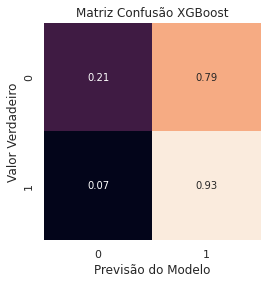

In [138]:
X_train_rus_scaled_xgb = X_train_rus_selector_xgb.copy()
X_test_scaled_xgb = X_test[columns_features_xgb].copy()

# standardizing numeric variables
for feature in list(columns_features_xgb):
  X_train_rus_scaled_xgb[feature] = scaler.fit_transform(X_train_rus_scaled_xgb[feature].values.reshape(-1,1))

  X_test_scaled_xgb[feature] = scaler.transform(X_test_scaled_xgb[feature].values.reshape(-1,1))

model_xgb.fit(X = X_train_rus_scaled_xgb, y = y_train_rus)

y_proba = model_xgb.predict_proba(X_test_scaled_xgb)
y_proba_df = pd.DataFrame(y_proba)

# calculating the prediction using the cutoff of 0.34
y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > 0.4 else 0)

print(classification_report(y_test, y_proba_df['Predict']))
print("AUC Score: ",roc_auc_score(y_test, y_proba[:,1]))
print("--------------------------------------------------------------------")

fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_proba_df['Predict'], normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

ax.set_xlabel("Previsão do Modelo")
ax.set_ylabel("Valor Verdadeiro")
ax.set_title("Matriz Confusão XGBoost")

plt.show()

In [ ]:
0# save model
filename = 'xgboost_undersampling.pkl'
pickle.dump(model_lr, open(filename, 'wb'))

# save scaler
filename = 'scaler_xgb_undersampling.sav'
pickle.dump(scaler, open(filename, 'wb'))